# import necessary modules

In [1]:
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.select import Select
import time
from time import sleep
from bs4 import BeautifulSoup as bs
import numpy as np
import datetime
from selenium.common.exceptions import NoSuchElementException
import re
import requests
from selenium.webdriver.chrome.options import Options
from tqdm import tqdm


# prepare chromedriver for scraping

In [113]:
chrome_options = Options()
chrome_options.add_argument('--user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3')
driver = webdriver.Chrome("/Users/masashi-ijichi/Downloads/chromedriver-mac-x64 4/chromedriver",options=chrome_options)

# access website for year 1912 to year 2023

In [114]:
year=[]
rank=[]
name=[]
pronounce_count=[]

for year_item in range(1912,2024):
    url = f"https://www.meijiyasuda.co.jp/enjoy/ranking/index.html#/year/{year_item}n"
    driver.get(url)
    time.sleep(5)
    html = driver.page_source
    soup = bs(html, "html.parser")
    for i in range(20,len(soup.find_all('li',class_='c-list-ranking__item'))):
        text=soup.find_all('li',class_='c-list-ranking__item')[i].text
        rank.append(text.split("位")[0])
        print(year_item)
        name.append(text.split("位")[1])
        pronounce_url_piece=soup.find_all('li',class_='c-list-ranking__item')[i].find('a')['href']
        url2 = f"https://www.meijiyasuda.co.jp{pronounce_url_piece}"
        driver.get(url2)
        time.sleep(5)
        
        html2 = driver.page_source
        soup2 = bs(html2, "html.parser")
        pronounce_count.append(len(soup2.find_all('li',class_='p-ranking-box__name')))
        year.append(year_item)
    

1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1912
1913
1913
1913
1913
1913
1913
1913
1913
1913
1913
1913
1913
1913
1913
1913
1913
1913
1913
1913
1913
1914
1914
1914
1914
1914
1914
1914
1914
1914
1914
1914
1914
1914
1914
1914
1914
1914
1914
1914
1914
1915
1915
1915
1915
1915
1915
1915
1915
1915
1915
1915
1915
1915
1915
1915
1915
1915
1915
1915
1915
1916
1916
1916
1916
1916
1916
1916
1916
1916
1916
1916
1916
1916
1916
1916
1916
1916
1916
1916
1916
1917
1917
1917
1917
1917
1917
1917
1917
1917
1917
1917
1917
1917
1917
1917
1917
1917
1917
1917
1917
1918
1918
1918
1918
1918
1918
1918
1918
1918
1918
1918
1918
1918
1918
1918
1918
1918
1918
1918
1918
1919
1919
1919
1919
1919
1919
1919
1919
1919
1919
1919
1919
1919
1919
1919
1919
1919
1919
1919
1919
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1920
1921
1921
1921
1921
1921
1921
1921
1921
1921
1921
1921
1921
1921
1921
1921
1921
1921
1921
1921
1921


# create a dataframe

In [115]:
df=pd.DataFrame()
df['name']=name
df['rank']=rank
df['pronounce_count']=pronounce_count
df['year']=year

# export the dataframe

In [116]:
df.to_excel('jpn_baby_name.xlsx',index=False)

In [120]:
df

,name,rank,pronounce_count,year
0,正一,1,0,1912
1,清,2,0,1912
2,正雄,3,0,1912
3,正,4,0,1912
4,茂,5,0,1912
...,...,...,...,...
2225,澪,5,2,2023
2226,芽依,5,1,2023
2227,心春,5,2,2023
2228,陽菜,9,8,2023


# when there is no reading options for a name, consider it has only one reading

In [353]:
reading_count=[]
for a in df['pronounce_count']:
    if a==0:
        reading_count.append(1)
    else:
        reading_count.append(a)

In [354]:
df['reading_count']=reading_count

<AxesSubplot:xlabel='year'>

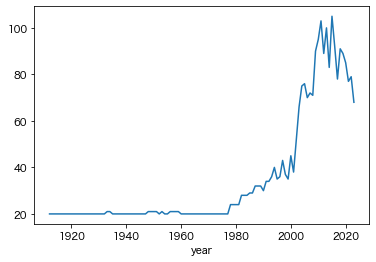

In [355]:
df.groupby('year')['reading_count'].sum().plot()

# create columns depending on the length of each name, separate a letter one by one and store it in the created column

In [357]:
max_length = df['name'].str.len().max()  
for i in range(max_length):
    df[f'name_char_{i+1}'] = df['name'].apply(lambda x: x[i] if i < len(x) else '')

In [358]:
df

,name,rank,pronounce_count,year,reading_count,name_char_1,name_char_2,name_char_3
0,正一,1,0,1912,1,正,一,
1,清,2,0,1912,1,清,,
2,正雄,3,0,1912,1,正,雄,
3,正,4,0,1912,1,正,,
4,茂,5,0,1912,1,茂,,
...,...,...,...,...,...,...,...,...
2235,澪,5,2,2023,2,澪,,
2236,芽依,5,1,2023,1,芽,依,
2237,心春,5,2,2023,2,心,春,
2238,陽菜,9,8,2023,8,陽,菜,


# use kanjiAPI to get information for each Chinese character

### get info for Chinese character stored in name_char_1

In [264]:
name_char_data=[]
character_list=[]

for character in df['name_char_1']:
    if character not in character_list:
   
        url = f"https://kanjiapi.dev/v1/kanji/{character}"
        
        
        response = requests.get(url, headers=headers)
        time.sleep(1)
        if response.status_code == 200 and response.json():
            name_char_data.append(response.json())
            print(character)
            time.sleep(1)
            character_list.append(character)
    
        else:
            name_char_data.append('not found')
            print(character)
            time.sleep(1)
        

正
清
茂
武
三
一
千
ハ
ハ
文
ヨ
キ
静
は
義
キ
ヨ
ハ
フ
マ
き
勇
実
秀
キ
ハ
き
ヨ
キ
ト
フ
光
キ
ハ
き
き
は
辰
キ
八
フ
キ
貞
博
キ
キ
愛
ハ
美
久
キ
キ
ハ
弘
和
ヨ
キ
キ
芳
キ
君
幸
敏
進
信
照
昭
節
典
孝
稔
洋
明
昇
隆
栄
良
勉
京
悦
勝
勲
功
紀
恵
修
豊
啓
誠
順
由
裕
浩
徹
智
聡
剛
真
哲
直
達
ゆ
学
健
陽
淳
英
崇
純
大
香
優
亮
竜
め
理
絵
翔
麻
拓
祐
雄
友
彩
あ
舞
あ
沙
成
瞳
駿
早
貴
茜
桃
翼
里
萌
遥
葵
佳
菜
康
楓
奈
陸
七
未
海
涼
匠
玲
蓮
亜
さ
さ
結
琴
颯
莉
太
悠
さ
凜
さ
花
百
輝
さ
空
さ
さ
ひ
さ
心
瑛
さ
ひ
歩
蒼
さ
樹
杏
湊
龍
ひ
芽
ひ
凛
朝
桜
さ
新
さ
咲
さ
さ
紬
律
詩
澪
凪
碧
暖


### get info for Chinese character stored in name_char_2

In [265]:
for character in  df[~df['name_char_2'].isin([''])]['name_char_2']:
    if character not in character_list:
   
        url = f"https://kanjiapi.dev/v1/kanji/{character}"
        
        
        response = requests.get(url, headers=headers)
        time.sleep(1)
        if response.status_code == 200 and response.json():
            name_char_data.append(response.json())
            print(character)
            time.sleep(1)
            character_list.append(character)
    
        else:
            name_char_data.append('not found')
            print(character)
            time.sleep(1)
        

治
郎
夫
代
ル
ナ
子
シ
ヨ
る
二
男
ヨ
シ
ル
ミ
サ
み
ヨ
ル
よ
シ
ミ
ミ
ミ
ヨ
ル
よ
み
る
ミ
重
ミ
ヨ
ヨ
ミ
ル
ミ
ヨ
ル
シ
ヨ
ミ
ヨ
利
之
彦
也
か
輔
織
穂
介
ぐ
平
衣
日
ゆ
ゆ
尋
地
夏
哉
摘
人
々
来
斗
乃
々
く
月
く
音
羽
く
央
く
く
く
く
な
向
く
く
な
夢
雅
く
生
な
春
依
な
く
く
く
く
希
茉


### get info for Chinese character stored in name_char_3

In [268]:
for character in  df[~df['name_char_3'].isin([''])]['name_char_3']:
    if character not in character_list:
   
        url = f"https://kanjiapi.dev/v1/kanji/{character}"
        
        
        response = requests.get(url, headers=headers)
        time.sleep(1)
        if response.status_code == 200 and response.json():
            name_char_data.append(response.json())
            print(character)
            time.sleep(1)
            character_list.append(character)
    
        else:
            name_char_data.append('not found')
            print(character)
            time.sleep(1)

り
み
み
み
ら
ら
ら
ら
ら
ら
ら
た
ら
ら
た
ら
た
た
ら
ら
ら
ら


# create a dataframe of Chinese character appeared in the previous dataframe

In [289]:
kanji=[]
kun=[]
on=[]
stroke=[]
meaning=[]
for i in range(0,len(name_char_data)):
    try:
        
        kanji.append(name_char_data[i]['kanji'])
        kun.append(name_char_data[i]['kun_readings'])
        on.append(name_char_data[i]['on_readings'])
        stroke.append(name_char_data[i]['stroke_count'])
        meaning.append(name_char_data[i]['meanings'])
    except:
        kanji.append('not found')
        kun.append('not found')
        on.append('not found')
        stroke.append('not found')
        meaning.append('not found')
    
    

In [292]:
kdf=pd.DataFrame()
kdf['kanji']=kanji
kdf['kun_reading']=kun
kdf['on_reading']=on
kdf['stroke_count']=stroke
kdf['meanig']=meaning

In [297]:
kdf=kdf[~kdf['kanji'].isin(['not found'])]

# merge baby name df with chinese character info df

In [370]:
dfm=dfm.merge(kdf,left_on='name_char_2',right_on='kanji',how='outer')
dfm[~dfm['name'].isna()]

,name,rank,pronounce_count,year,reading_count,name_char_1,name_char_2,name_char_3,gender,kanji_x,kun_reading_x,on_reading_x,stroke_count_x,meanig_x,kanji_y,kun_reading_y,on_reading_y,stroke_count_y,meanig_y
0,正一,1.0,0.0,1912.0,1.0,正,一,,male,正,"[ただ.しい, ただ.す, まさ, まさ.に]","[ショウ, セイ]",5,"[10**40, correct, justice, righteous]",一,"[ひと-, ひと.つ]","[イチ, イツ]",1,"[one, one radical (no.1)]"
1,正一,7.0,0.0,1913.0,1.0,正,一,,male,正,"[ただ.しい, ただ.す, まさ, まさ.に]","[ショウ, セイ]",5,"[10**40, correct, justice, righteous]",一,"[ひと-, ひと.つ]","[イチ, イツ]",1,"[one, one radical (no.1)]"
2,正一,6.0,0.0,1914.0,1.0,正,一,,male,正,"[ただ.しい, ただ.す, まさ, まさ.に]","[ショウ, セイ]",5,"[10**40, correct, justice, righteous]",一,"[ひと-, ひと.つ]","[イチ, イツ]",1,"[one, one radical (no.1)]"
3,正一,10.0,0.0,1915.0,1.0,正,一,,male,正,"[ただ.しい, ただ.す, まさ, まさ.に]","[ショウ, セイ]",5,"[10**40, correct, justice, righteous]",一,"[ひと-, ひと.つ]","[イチ, イツ]",1,"[one, one radical (no.1)]"
4,正一,8.0,0.0,1917.0,1.0,正,一,,male,正,"[ただ.しい, ただ.す, まさ, まさ.に]","[ショウ, セイ]",5,"[10**40, correct, justice, righteous]",一,"[ひと-, ひと.つ]","[イチ, イツ]",1,"[one, one radical (no.1)]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,芽依,5.0,1.0,2023.0,1.0,芽,依,,female,芽,[め],[ガ],8,"[bud, germ, spear, sprout]",依,[よ.る],"[イ, エ]",8,"[consequently, depend on, due to, reliant, the..."
2236,咲良,5.0,2.0,2016.0,2.0,咲,良,,female,咲,"[-ざき, さ.く]",[ショウ],9,"[bloom, blossom]",良,"[-い.い, -よ.い, い.い, よ.い]",[リョウ],7,"[good, pleasing, skilled]"
2237,咲良,1.0,2.0,2017.0,2.0,咲,良,,female,咲,"[-ざき, さ.く]",[ショウ],9,"[bloom, blossom]",良,"[-い.い, -よ.い, い.い, よ.い]",[リョウ],7,"[good, pleasing, skilled]"
2238,咲茉,9.0,1.0,2023.0,1.0,咲,茉,,female,咲,"[-ざき, さ.く]",[ショウ],9,"[bloom, blossom]",茉,[],"[バツ, マ, マツ]",8,[jasmine]


# add gender info to merged dataframe

In [363]:
gen_info = ['male'] * 10 + ['female'] * 10
gen_info = (gen_info * (len(df) // 20 + 1))[:len(dfm)]

In [360]:
dfm['gender']=gen_info

In [375]:
dfm

,name,rank,pronounce_count,year,reading_count,name_char_1,name_char_2,name_char_3,gender,kanji_x,...,kanji_y,kun_reading_y,on_reading_y,stroke_count_y,meanig_y,kanji,kun_reading,on_reading,stroke_count,meanig
0,正一,1.0,0.0,1912.0,1.0,正,一,,male,正,...,一,"[ひと-, ひと.つ]","[イチ, イツ]",1,"[one, one radical (no.1)]",NaN,NaN,NaN,NaN,NaN
1,正一,7.0,0.0,1913.0,1.0,正,一,,male,正,...,一,"[ひと-, ひと.つ]","[イチ, イツ]",1,"[one, one radical (no.1)]",NaN,NaN,NaN,NaN,NaN
2,正一,6.0,0.0,1914.0,1.0,正,一,,male,正,...,一,"[ひと-, ひと.つ]","[イチ, イツ]",1,"[one, one radical (no.1)]",NaN,NaN,NaN,NaN,NaN
3,正一,10.0,0.0,1915.0,1.0,正,一,,male,正,...,一,"[ひと-, ひと.つ]","[イチ, イツ]",1,"[one, one radical (no.1)]",NaN,NaN,NaN,NaN,NaN
4,正一,8.0,0.0,1917.0,1.0,正,一,,male,正,...,一,"[ひと-, ひと.つ]","[イチ, イツ]",1,"[one, one radical (no.1)]",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,さくら,5.0,1.0,2018.0,1.0,さ,く,ら,female,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2236,ひなた,9.0,1.0,2007.0,1.0,ひ,な,た,female,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2237,ひなた,10.0,1.0,2009.0,1.0,ひ,な,た,female,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2238,ひなた,4.0,1.0,2012.0,1.0,ひ,な,た,female,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# convert year to datetime formate and extract only year

In [381]:
dfm['year']=pd.to_datetime(dfm['year'], format='%Y').dt.year

/var/folders/j9/xcjc_rqj4c5g9t78qm2fh1m40000gn/T/ipykernel_55509/3135253380.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfm['year']=pd.to_datetime(dfm['year'], format='%Y').dt.year


# export dataframe

In [ ]:
dfnew=dfm.to_excel('jpnbabyname0704.xlsx',index=False)

# import dataframe

In [400]:
dfnew=pd.read_excel('jpnbabyname0704.xlsx')

In [401]:
dfnew

,name,rank,pronounce_count,year,reading_count,name_char_1,name_char_2,name_char_3,gender,kanji_x,...,kanji_y,kun_reading_y,on_reading_y,stroke_count_y,meanig_y,kanji,kun_reading,on_reading,stroke_count,meanig
0,正一,1,0,1912,1,正,一,NaN,male,正,...,一,"['ひと-', 'ひと.つ']","['イチ', 'イツ']",1.0,"['one', 'one radical (no.1)']",NaN,NaN,NaN,NaN,NaN
1,正雄,3,0,1912,1,正,雄,NaN,male,正,...,雄,"['お-', 'おす', 'おん']",['ユウ'],12.0,"['excellence', 'hero', 'leader', 'male', 'masc...",NaN,NaN,NaN,NaN,NaN
2,武雄,6,0,1912,1,武,雄,NaN,male,武,...,雄,"['お-', 'おす', 'おん']",['ユウ'],12.0,"['excellence', 'hero', 'leader', 'male', 'masc...",NaN,NaN,NaN,NaN,NaN
3,正,4,0,1912,1,正,NaN,NaN,male,正,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,清,2,0,1912,1,清,NaN,NaN,male,清,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,結愛,4,14,2023,14,結,愛,NaN,female,結,...,愛,"['いと.しい', 'お.しむ', 'かな.しい', 'まな', 'め.でる']",['アイ'],13.0,"['affection', 'favourite', 'love']",NaN,NaN,NaN,NaN,NaN
2236,颯真,6,2,2023,2,颯,真,NaN,male,颯,...,真,"['ま', 'ま-', 'まこと']",['シン'],10.0,"['Buddhist sect', 'reality', 'true']",NaN,NaN,NaN,NaN,NaN
2237,心春,5,2,2023,2,心,春,NaN,female,心,...,春,['はる'],['シュン'],9.0,"['spring (season)', 'springtime']",NaN,NaN,NaN,NaN,NaN
2238,芽依,5,1,2023,1,芽,依,NaN,female,芽,...,依,['よ.る'],"['イ', 'エ']",8.0,"['consequently', 'depend on', 'due to', 'relia...",NaN,NaN,NaN,NaN,NaN


# calculate sum of stroke count and create a new column called strokes

In [408]:
dfnew['strokes']=dfnew['stroke_count'].fillna(0).astype(int)+dfnew['stroke_count_x'].fillna(0).astype(int)+dfnew['stroke_count_y'].fillna(0).astype(int)

<AxesSubplot:xlabel='year'>

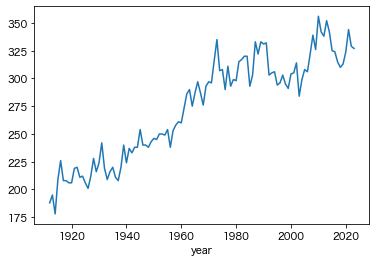

In [409]:
dfnew.groupby('year').strokes.sum().plot()

# calculate avereage stroke and turn it to dataframe before exporting in a format fit for flourish

In [423]:
dfstrokes=dfnew.groupby(['year','gender']).strokes.sum().reset_index()

In [424]:
dfstrokes['avg strokes']=dfstrokes['strokes']/10

In [425]:
dfstrokes.pivot(index='year', columns='gender', values='avg strokes').reset_index().to_excel('jpbaby_gender_strokes.xlsx',index=False)

# calculate avereage reading and turn it to dataframe before exporting in a format fit for flourish

In [428]:
dfreading=dfnew.groupby(['year','gender']).reading_count.sum().reset_index()
dfreading['avg reading']=dfreading['reading_count']/10

In [429]:
dfreading.pivot(index='year', columns='gender', values='avg reading').reset_index().to_excel('jpbaby_gender_reading.xlsx',index=False)

In [558]:
dfnew.columns

Index(['name', 'rank', 'pronounce_count', 'year', 'reading_count',
       'name_char_1', 'name_char_2', 'name_char_3', 'gender', 'kanji_x',
       'kun_reading_x', 'on_reading_x', 'stroke_count_x', 'meanig_x',
       'kanji_y', 'kun_reading_y', 'on_reading_y', 'stroke_count_y',
       'meanig_y', 'kanji', 'kun_reading', 'on_reading', 'stroke_count',
       'meanig', 'strokes'],
      dtype='object')

# checking which name has  the

In [559]:
dfnew[dfnew.year.isin([2023])][['name','strokes','gender','reading_count']]

,name,strokes,gender,reading_count
2220,蓮,13,male,1
2221,蒼,13,male,4
2222,湊,12,male,4
2223,凛,15,female,1
2224,紬,11,female,1
2225,律,9,male,1
2226,澪,16,female,2
2227,凪,6,male,2
2228,碧,14,male,2
2229,暖,13,male,3
